# Test the runtime of IBD calling

In [4]:
import socket as socket
import os as os
import sys as sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from itertools import combinations

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM O2 Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/ibd_euro/"  # The Path on Harvard Cluster
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())

#sys.path.append("/n/groups/reich/hringbauer/git/hapBLOCK/python3/") 
#from main import HMM_Full
#from ancIBD.run import hapBLOCK_chrom, run_plot_pair
sys.path.insert(0,"/n/groups/reich/hringbauer/git/hapBLOCK/package/")  # hack to get development package first in path
from ancIBD.run import hapBLOCK_chroms, hapBLOCK_times

### hapsburgImport
#sys.path.insert(0,"/n/groups/reich/hringbauer/git/HAPSBURG/package/")
#from hapsburg.PackagesSupport.parallel_runs.helper_functions import combine_individual_data

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the default
rcParams['font.sans-serif'] = ['Arial']  # Make sure to have the font installed (it is on cluster for Harald)

compute-a-16-170.o2.rc.hms.harvard.edu
HSM O2 Computational partition detected.
/n/groups/reich/hringbauer/git/ibd_euro


# Do a single run for one pair

In [5]:
### From the all.v1 run
version = "53.1"
folder_in =  f"/n/groups/reich/hringbauer/git/hapBLOCK/data/hdf5/1240k_v{version}/ch" # for hdf5
path_meta =  f"/n/groups/reich/hringbauer/git/ibd_euro/data/iid_lists/iid_ibd_v{version}.tsv" # for iids

df = pd.read_csv(path_meta, sep="\t")
print(f'Loaded Meta File with {len(df)} Samples')
min_cov = np.min(df["n_cov_snp"])
print(f"Minimum #1240k SNPs: {min_cov}")

Loaded Meta File with 8818 Samples
Minimum #1240k SNPs: 600109


# 0) Define Timing functions for various tests (linear loading, batch loading)

In [30]:
def time_2samples_wg(iid2, chs=range(1,23)):
    """Times two samples for their whole genome.
    Return: Runtime, IBD df"""
    start = time() # Start Clock
    df_ibds = []
    dft = pd.DataFrame(columns=["iid1","iid2", 'ch', "t_load", "t_pp", "t_run"])
    
    for ch in chs:
        df_ibd, t1, t2, t3, t4 = hapBLOCK_times(folder_in=folder_in,
                                     iids=iids2, run_iids=[iids2],
                                     ch=ch, folder_out="",
                                     output=False, prefix_out='', logfile=False,
                                     l_model='h5', e_model='haploid_gl2', h_model='FiveStateScaled', 
                                     t_model='standard', p_col="variants/AF_ALL",
                                     ibd_in=1, ibd_out=10, ibd_jump=400,
                                     min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                                     processes=1)
        dft.loc[len(dft)] = [iid2[0],iid2[1],ch, t2-t1, t3-t2, t4-t3]
        df_ibds.append(df_ibd)
    df_ibd = pd.concat(df_ibds)
    runtime = time() - start # Runtime in s
    
    return runtime, df_ibd, dft


def run_time_random_batch(n=100):
    """Run Time of a Random Batch"""
    print(f"Sample Number: {n}")
    

    pairs = [np.random.choice(df["iid"], 2) for _ in range(n)]
    iids = list(set(np.concatenate(pairs)))
    dft = pd.DataFrame(columns=["n", 'ch', "t_load", "t_pp", "t_run", "t_full"])
    
    for ch in range(1,23):
        print(f"Running Chr.: {ch}...")
        
        start = time()
        df_ibd, t1, t2, t3, t4 = hapBLOCK_times(folder_in=folder_in,
                                     iids=iids, run_iids=pairs,
                                     ch=ch, folder_out="",
                                     output=False, prefix_out='', logfile=False,
                                     l_model='h5', e_model='haploid_gl2', h_model='FiveStateScaled', 
                                     t_model='standard', p_col="variants/AF_ALL",
                                     ibd_in=1, ibd_out=10, ibd_jump=400,
                                     min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                                     processes=1)
        runtime2 = time() - start
        dft.loc[len(dft)] = [n, ch, t2-t1, t3-t2, t4-t3, runtime2]
    return dft


def run_time_allpairs(n=10):
    """Run Time of a Random Batch"""
    print(f"Sample Number: {n}")
    

    iids =  np.random.choice(df["iid"], n)
    pairs = list(combinations(iids, 2))
    print(f"Running {len(pairs)} Pairs of samples when loading {n} IIDs")
    dft = pd.DataFrame(columns=["n", 'ch', "t_load", "t_pp", "t_run", "t_full"])
    
    
    for ch in range(1,23):
        print(f"Running Chr.: {ch}...")
        start = time()
        df_ibd2 = df_ibd, t1, t2, t3, t4 = hapBLOCK_times(folder_in=folder_in,
                                     iids=iids, run_iids=pairs,
                                     ch=ch, folder_out="",
                                     output=False, prefix_out='', logfile=False,
                                     l_model='h5', e_model='haploid_gl2', h_model='FiveStateScaled', 
                                     t_model='standard', p_col="variants/AF_ALL",
                                     ibd_in=1, ibd_out=10, ibd_jump=400,
                                     min_cm=6, cutoff_post=0.99, max_gap=0.0075,
                                     processes=1)
        runtime = time() - start
        dft.loc[len(dft)] = [n, ch, t2-t1, t3-t2, t4-t3, runtime]
    
    return dft

In [32]:
#iids2 = df["iid"][:2]
iids2 = ["I22118", "I22122"]
runtime, df_ibd, dft = time_2samples_wg(iids2)

## A) Do large scale testing of pairs

In [ ]:
n = 100

runtimes, sumibd, load_times, pp_times, ibd_times = np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n), np.zeros(n)
iid1, iid2 = np.zeros(n, dtype="object"), np.zeros(n, dtype="object")

for i in range(n):
    print(f"Doing run: {i}")
    iids2 = np.random.choice(df["iid"], 2)
    iid1[i], iid2[i] = iids2
    runtime, df_ibd, dft = time_2samples_wg(iids2)
    runtimes[i] = runtime
    load_times[i] = np.sum(dft["t_load"])
    pp_times[i] = np.sum(dft["t_pp"])
    ibd_times[i] = np.sum(dft["t_run"])
    
    sumibd[i] = np.sum(df_ibd["lengthM"])
    
dft = pd.DataFrame({"iid1":iid1, "iid2":iid2, "sumIBD":sumibd, "runtime":runtimes, 
                    "t_load":load_times, "t_pp": pp_times, "t_run":ibd_times})

In [ ]:
dft

In [38]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/linear100b.tsv"
dft.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft)} runtimes to: {savepath}")

Saved 100 runtimes to: /n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/linear100b.tsv


## B) Do large scale testing of linear loading of pairs

In [ ]:
dft = run_time_random_batch(n=2)

In [ ]:
dft

### Run the full test for various batch sizes

In [ ]:
ns = [2, 5, 10, 20, 50, 100]
dfts  = [run_time_random_batch(n=n) for n in ns]
dft2 = pd.concat(dfts)
#dft2 = pd.DataFrame({"#Pairs":ns, "runtime":runtimes})

In [ ]:
dft2#.groupby("n")

In [64]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100b.tsv"
dft2.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft2)} runtimes to: {savepath}")

Saved 132 runtimes to: /n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100b.tsv


## C) Run pairs of samples when loading batch of individuals

In [ ]:
dft = run_time_allpairs(4)

## Do the array run

In [14]:
ns = np.arange(2,17,2)
dfts  = [run_time_allpairs(n=n) for n in ns]
dft3 = pd.concat(dfts)
#dft3 = pd.DataFrame({"#samples":ns, "#pairs":ns*(ns-1)/2, "runtime":runtimes})

Sample Number: 2
Running 1 Pairs of samples when loading 2 IIDs
Running Chr.: 1...
Running Chr.: 2...
Running Chr.: 3...
Running Chr.: 4...
Running Chr.: 5...
Running Chr.: 6...
Running Chr.: 7...
Running Chr.: 8...
Running Chr.: 9...
Running Chr.: 10...
Running Chr.: 11...
Running Chr.: 12...
Running Chr.: 13...
Running Chr.: 14...
Running Chr.: 15...
Running Chr.: 16...
Running Chr.: 17...
Running Chr.: 18...
Running Chr.: 19...
Running Chr.: 20...
Running Chr.: 21...
Running Chr.: 22...
Sample Number: 4
Running 6 Pairs of samples when loading 4 IIDs
Running Chr.: 1...
Running Chr.: 2...
Running Chr.: 3...
Running Chr.: 4...
Running Chr.: 5...
Running Chr.: 6...
Running Chr.: 7...
Running Chr.: 8...
Running Chr.: 9...
Running Chr.: 10...
Running Chr.: 11...
Running Chr.: 12...
Running Chr.: 13...
Running Chr.: 14...
Running Chr.: 15...
Running Chr.: 16...
Running Chr.: 17...
Running Chr.: 18...
Running Chr.: 19...
Running Chr.: 20...
Running Chr.: 21...
Running Chr.: 22...
Sample Num

In [15]:
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches16b.tsv"
dft3.to_csv(savepath, sep="\t", index=False)
print(f"Saved {len(dft3)} runtimes to: {savepath}")

Saved 176 runtimes to: /n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches16b.tsv


In [17]:
dft3

,n,ch,t_load,t_pp,t_run,t_full
0,2.0,1.0,3.745419,0.075758,0.030315,3.851553
1,2.0,2.0,1.976340,0.086004,0.041073,2.103526
2,2.0,3.0,1.732854,0.066535,0.028184,1.827632
3,2.0,4.0,1.056698,0.058291,0.022353,1.137397
4,2.0,5.0,0.948075,0.058091,0.026028,1.032258
...,...,...,...,...,...,...
17,16.0,18.0,5.947063,0.024659,1.229088,7.200960
18,16.0,19.0,2.587710,0.013285,0.789831,3.390967
19,16.0,20.0,3.560872,0.021203,1.086511,4.668732
20,16.0,21.0,3.154840,0.011736,0.736384,3.903102


# 2)a) Plot the runtime with the updated results

In [ ]:
df1 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/linear100.tsv", sep="\t")
df2 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100.tsv", sep="\t")
df3 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches.tsv", sep="\t")

# 2) Plot the runtime

In [3]:
df2 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs100.tsv", sep="\t")
df3 = pd.read_csv("/n/groups/reich/hringbauer/git/hapBLOCK/output/tables/runtimes/pairs_batches.tsv", sep="\t")

In [7]:
df1

,iid1,iid2,runtime,sumIBD
0,I18207,I29668,23.835721,0.062472
1,VK174_noUDG.SG,I14669,26.379042,0.000000
2,I26455,MOK28A.SG,26.608083,0.000000
3,I7133.SG,I24813,23.660140,0.000000
4,I30843,I7864,27.667068,0.000000
...,...,...,...,...
95,I34375,I11547,19.545852,0.000000
96,N49_noUDG.SG,I31343,19.811297,0.000000
97,I22056,I14104,19.752601,0.094900
98,I6262,ELT006_merged,19.902245,0.000000


Saved to /n/groups/reich/hringbauer/git/hapBLOCK/figs/runtime/runtime_benchmark.pdf


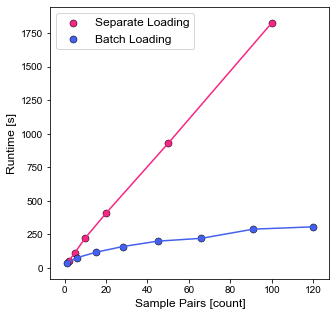

In [176]:
fs=12
lw = .5
s = 50
savepath = "/n/groups/reich/hringbauer/git/hapBLOCK/figs/runtime/runtime_benchmark.pdf"

plt.figure(figsize=(5,5))
ax = plt.gca()

#ax.plot([0,df2["#Pairs"].values[-1]],[0, df2["runtime"].values[-1]], c="gray", linestyle='dashed')
ax.plot(df2["#Pairs"].values, df2["runtime"].values, c="#f72585")
ax.scatter(df2["#Pairs"], df2["runtime"], ec="k", s=s, c="#f72585", label="Separate Loading", lw=lw)

ax.plot(df3["#pairs"].values, df3["runtime"].values, c="#4361ee")
ax.scatter(df3["#pairs"], df3["runtime"], ec="k", s=s, c="#4361ee", label="Batch Loading", lw=lw)

ax.legend(loc="upper left", fontsize=fs)
ax.set_xlabel("Sample Pairs [count]", fontsize=fs)
ax.set_ylabel("Runtime [s]", fontsize=fs)

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")
    
plt.show()

# 2) Make Benchmarks with load time and run time

# Find out Platform CPU

In [82]:
import os, platform, subprocess, re

def get_processor_name():
    if platform.system() == "Windows":
        print("Dindows")
        return platform.processor()
    elif platform.system() == "Linux":
        print("Linux")
        command = "cat /proc/cpuinfo"
        all_info = subprocess.check_output(command, shell=True).decode().strip()
        for line in all_info.split("\n"):
            if "model name" in line:
                return re.sub( ".*model name.*:", "", line,1)
    return ""

In [83]:
get_processor_name()

Linux


' Intel(R) Xeon(R) CPU E5-2697 v3 @ 2.60GHz'

# Area 51

In [10]:
from time import time

In [18]:
start = time()
a = np.arange(100000000)
a = np.square(a)
end = time()
end - start

1.2364563941955566